In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.model_selection import train_test_split
import copy
import matplotlib.pyplot as plt
import numpy as np
import torchvision

### We check whether we train with GPU

In [2]:
# Define the device
device = torch.device('mps')

from util import to_f32

# Define the data directory
data_dir = '../data'  # Update this path

# Define transforms for the data
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Load the full dataset
full_dataset = datasets.ImageFolder(data_dir, transform=data_transforms['train'])

# Split the dataset into train, validation, and test sets (70% train, 15% val, 15% test)
train_idx, temp_idx = train_test_split(list(range(len(full_dataset))), test_size=0.3, stratify=full_dataset.targets)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, stratify=[full_dataset.targets[i] for i in temp_idx])

# Create subsets for each set
train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)
test_dataset = Subset(full_dataset, test_idx)

# Apply appropriate transforms to each subset
train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

# Create dataloaders for each set
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get dataset sizes
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test': len(test_dataset)
}


In [3]:
# Get class names
class_names = full_dataset.classes
class_names

['cocci', 'healthy', 'ncd', 'salmo']

## Showcasing an array of images and their labels

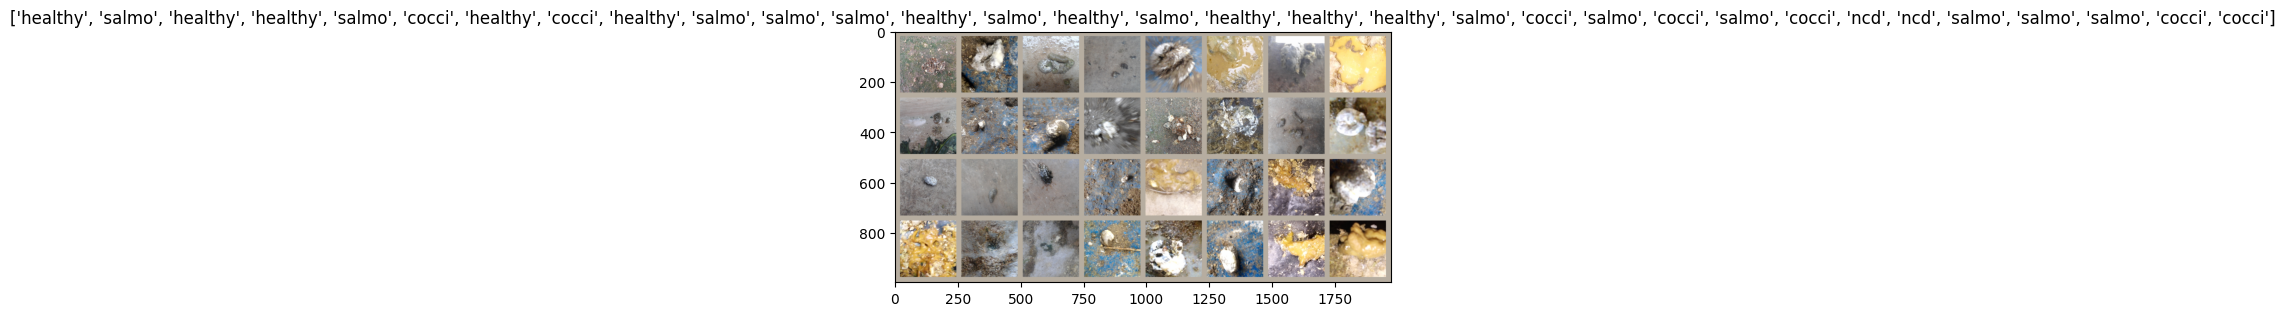

In [4]:
# Define a function to show images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch with larger padding and bigger images
out = torchvision.utils.make_grid(inputs, padding=20, pad_value=1, scale_each=True)

# Display batch with labels
imshow(out, title=[class_names[x] for x in classes])
plt.show()


In [5]:
import torchvision.models.vgg as vgg

# Load a pretrained VGG19 model
model_ft = vgg.vgg19_bn(weights = vgg.VGG19_BN_Weights.DEFAULT)

# Modify the classifier to match the number of classes
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

# Move the model to the appropriate device
model_ft = model_ft.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

In [6]:
# Function to train and validate the model
from tqdm import tqdm

def train_model(model, criterion, optimizer, num_epochs = 25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            processed_samples = 0

            # Use tqdm to create a progress bar
            with tqdm(dataloaders[phase], unit='batch') as t:
                for inputs, labels in t:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    processed_samples += inputs.size(0)

                    # Update the progress bar description
                    t.set_description(f'{phase} Loss: {running_loss / processed_samples:.4f} Acc: {running_corrects / processed_samples:.4f}')

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print(f'Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model


In [7]:
# Train the model
model_ft = train_model(model_ft, criterion, optimizer, num_epochs=25)

# Save the model
torch.save(model_ft.state_dict(), 'vgg.pth')

Epoch 0/24
----------


train Loss: 0.3223 Acc: 0.8874: 100%|██████████| 149/149 [03:37<00:00,  1.46s/batch]


train Loss: 0.3223 Acc: 0.8874


val Loss: 0.0761 Acc: 0.9765: 100%|██████████| 32/32 [00:37<00:00,  1.17s/batch]


val Loss: 0.0761 Acc: 0.9765

Epoch 1/24
----------


train Loss: 0.0638 Acc: 0.9803: 100%|██████████| 149/149 [03:34<00:00,  1.44s/batch]


train Loss: 0.0638 Acc: 0.9803


val Loss: 0.0614 Acc: 0.9814: 100%|██████████| 32/32 [00:38<00:00,  1.19s/batch]


val Loss: 0.0614 Acc: 0.9814

Epoch 2/24
----------


train Loss: 0.0252 Acc: 0.9933: 100%|██████████| 149/149 [03:26<00:00,  1.38s/batch]


train Loss: 0.0252 Acc: 0.9933


val Loss: 0.0453 Acc: 0.9853: 100%|██████████| 32/32 [00:37<00:00,  1.16s/batch]


val Loss: 0.0453 Acc: 0.9853

Epoch 3/24
----------


train Loss: 0.0153 Acc: 0.9952: 100%|██████████| 149/149 [03:28<00:00,  1.40s/batch]


train Loss: 0.0153 Acc: 0.9952


val Loss: 0.0483 Acc: 0.9863: 100%|██████████| 32/32 [00:34<00:00,  1.09s/batch]


val Loss: 0.0483 Acc: 0.9863

Epoch 4/24
----------


train Loss: 0.0068 Acc: 0.9987: 100%|██████████| 149/149 [19:41<00:00,  7.93s/batch]   


train Loss: 0.0068 Acc: 0.9987


val Loss: 0.0457 Acc: 0.9863: 100%|██████████| 32/32 [00:36<00:00,  1.14s/batch]


val Loss: 0.0457 Acc: 0.9863

Epoch 5/24
----------


train Loss: 0.0057 Acc: 0.9985: 100%|██████████| 149/149 [10:02<00:00,  4.04s/batch]  


train Loss: 0.0057 Acc: 0.9985


val Loss: 0.0435 Acc: 0.9863: 100%|██████████| 32/32 [00:35<00:00,  1.10s/batch]


val Loss: 0.0435 Acc: 0.9863

Epoch 6/24
----------


train Loss: 0.0035 Acc: 0.9998: 100%|██████████| 149/149 [03:25<00:00,  1.38s/batch]


train Loss: 0.0035 Acc: 0.9998


val Loss: 0.0456 Acc: 0.9863: 100%|██████████| 32/32 [00:37<00:00,  1.18s/batch]


val Loss: 0.0456 Acc: 0.9863

Epoch 7/24
----------


train Loss: 0.0036 Acc: 0.9992:  80%|███████▉  | 119/149 [02:28<00:41,  1.37s/batch]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x114206840>
Traceback (most recent call last):
  File "/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/Users/domantas.keturakis/Projects/PoultryDiseaseDetection/venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1443, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/python@3.12/3.12.3/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/popen_fork.py", line 40, in wait
    if not wa

KeyboardInterrupt: 

### Model evaluation

In [ ]:
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score

def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        with tqdm(total=len(dataloader.dataset), unit=' samples') as progress_bar:
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)

                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

                progress_bar.update(inputs.size(0))

    return y_true, y_pred

# Evaluate the model on the test set
y_true, y_pred = evaluate_model(model_ft, dataloaders['test'])

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Calculate classification report
class_names = full_dataset.classes
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))


In [ ]:
import torch
import matplotlib.pyplot as plt

def show_examples(model, dataloader, class_names, num_examples=1):
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            if i >= num_examples:
                break

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                true_label = class_names[labels[j]]
                predicted_label = class_names[preds[j]]

                # Normalize image
                input_image = inputs[j].cpu()
                image = input_image.permute(1, 2, 0).numpy()

                # Normalize pixel values to [0, 1]
                image = (image - image.min()) / (image.max() - image.min())

                plt.imshow(image)
                plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_label}')
                plt.show()

# Show examples
show_examples(model_ft, dataloaders['test'], class_names, num_examples=1)
